In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
 pd.set_option('display.max_rows', 50)

# Analysis

In [3]:
# load data
df = pd.read_csv(r'..\data\processed\trips_custom_variables.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str}, parse_dates = ['start_time','end_time'])

## distance

compare distances traveled

In [4]:
# average distance by sex
df.groupby("sex").DISTANCIA_VIAJE.describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Man,101580.0,7.912443,48.427322,0.0,0.720371,2.439516,8.663173,4517.331249
Woman,121164.0,6.866701,64.050900,0.0,0.602751,1.900106,6.813408,4521.973558


**weight by ELE_G_POND_ESC2 (weight of trip)**

In [5]:
# weighted average distance by sex
df["weighted_dist"] = df.DISTANCIA_VIAJE * df.ELE_G_POND_ESC2

# get the weighted mean distance
df_sex_sum = df.groupby("sex").sum()
df_sex_sum.weighted_dist / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      7.887399
Woman    6.419492
dtype: float64

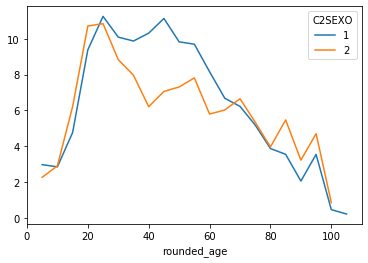

In [6]:
# average distance by age
x = df.groupby(["rounded_age", "C2SEXO"]).agg({"DISTANCIA_VIAJE":"mean"})
x = x.reset_index().pivot(index='rounded_age', columns='C2SEXO', values='DISTANCIA_VIAJE')
x.plot()

### amount of trips

In [7]:
# average amount of trips by sex
df.reset_index().groupby(["ID_HOGAR", "ID_IND", "sex"]).count().groupby("sex").mean().ID_VIAJE

sex
Man      2.604014
Woman    2.630854
Name: ID_VIAJE, dtype: float64

**weight by ELE_G_POND (weight of individual)**

In [8]:
# weighted average amount or trips by sex
df_ind = df.groupby(["ID_HOGAR", "ID_IND", "sex"]).ELE_G_POND.agg(['mean', 'sum'])
df_ind_sex_sum = df_ind.groupby("sex").sum()
df_ind_sex_sum['sum'] / df_ind_sex_sum['mean']

sex
Man      2.641541
Woman    2.682569
dtype: float64

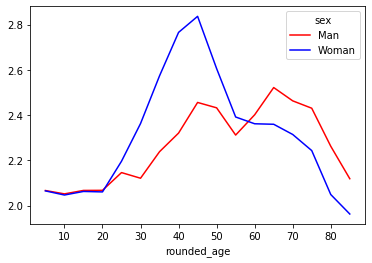

In [196]:
# amount of trips by age and sex

t_age = df.groupby(["rounded_age", "sex"]).agg({"ID_VIAJE":"mean"}).reset_index()

t_age = t_age[t_age.rounded_age < 90]
t_age = t_age.pivot(index='rounded_age', columns='sex', values='ID_VIAJE')
t_age.sort_index().plot(kind = "line", color = ["red", "blue"] )

**absolute amount of trips by gender and age**

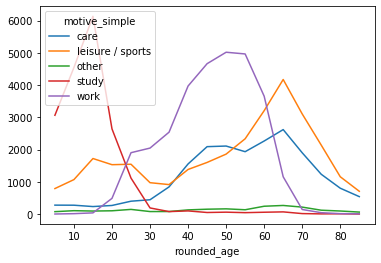

In [198]:
# amount of trips by purpose by age and sex
t_age = df.loc[df.sex == "Man"].groupby(["rounded_age", "motive_simple"]).agg({"ELE_G_POND_ESC2": "count"}).reset_index()
t_age = t_age[t_age.rounded_age < 90]
t_age = t_age.pivot(index='rounded_age', columns='motive_simple', values='ELE_G_POND_ESC2')
t_age.sort_index().plot(kind = "line")

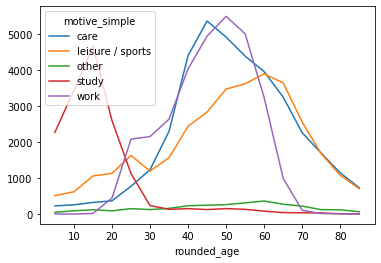

In [200]:
# amount of trips by purpose by age and sex
t_age = df.loc[df.sex == "Woman"].groupby(["rounded_age", "motive_simple"]).agg({"ELE_G_POND_ESC2": "count"}).reset_index()
t_age = t_age[t_age.rounded_age < 90]
t_age = t_age.pivot(index='rounded_age', columns='motive_simple', values='ELE_G_POND_ESC2')
t_age.sort_index().plot(kind = "line")

In [100]:
# what trip motive do the different age groups have?
# pd.DataFrame(df.groupby(["age_group", "sex"]).motive_simple.value_counts(normalize = True))

**weighted percentage of trips purposes**

In [152]:
sum_of_weighted_trips = pd.DataFrame(df.groupby(["age_group", "sex"]).sum("ELE_G_POND_ESC2")).reset_index()[["age_group", "sex","ELE_G_POND_ESC2"]]

weighted_trips = df.groupby(["age_group", "sex", "motive_simple"]).sum("ELE_G_POND_ESC2").reset_index().set_index(["age_group", "sex"])[["motive_simple", "ELE_G_POND_ESC2"]]
weighted_trips = weighted_trips.join(sum_of_weighted_trips.set_index(["age_group", "sex"]), rsuffix = "_total")

weighted_trips["perc"] = weighted_trips.ELE_G_POND_ESC2 / weighted_trips.ELE_G_POND_ESC2_total * 100

weighted_trips.sort_values(["age_group", "sex", "perc"])

motive_simple  ELE_G_POND_ESC2  ELE_G_POND_ESC2_total  \
age_group    sex                                                               
adults       Man               study     5.645363e+04           3.340948e+06   
             Man               other     6.448315e+04           3.340948e+06   
             Man                care     6.570759e+05           3.340948e+06   
             Man    leisure / sports     6.859525e+05           3.340948e+06   
             Man                work     1.876983e+06           3.340948e+06   
             Woman             study     7.325263e+04           3.995752e+06   
             Woman             other     8.424099e+04           3.995752e+06   
             Woman  leisure / sports     8.836818e+05           3.995752e+06   
             Woman              care     1.353040e+06           3.995752e+06   
             Woman              work     1.601537e+06           3.995752e+06   
kids         Man                work     4.818672e+03           1.285025e+06   
             Man               other     1.900734e+04           1.285025e+06   
             Man                care     5.092642e+04           1.285025e+06   
             Man    leisure / sports     2.365854e+05           1.285025e+06   
             Man               study     9.736871e+05           1.285025e+06   
             Woman              work     2.574304e+03           1.203685e+06   
             Woman             other     2.330896e+04           1.203685e+06   
             Woman              care     6.604836e+04           1.203685e+06   
             Woman  leisure / sports     1.842930e+05           1.203685e+06   
             Woman             study     9.274600e+05           1.203685e+06   
seniors      Man               study     1.276931e+04           2.397749e+06   
             Man               other     7.584964e+04           2.397749e+06   
             Man                work     5.304932e+05           2.397749e+06   
             Man                care     7.087117e+05           2.397749e+06   
             Man    leisure / sports     1.069925e+06           2.397749e+06   
             Woman             study     1.960610e+04           2.524022e+06   
             Woman             other     9.155860e+04           2.524022e+06   
             Woman              work     4.107989e+05           2.524022e+06   
             Woman              care     9.835155e+05           2.524022e+06   
             Woman  leisure / sports     1.018543e+06           2.524022e+06   
young adults Man               other     1.224303e+04           5.393564e+05   
             Man                care     3.546465e+04           5.393564e+05   
             Man                work     1.170980e+05           5.393564e+05   
             Man    leisure / sports     1.682636e+05           5.393564e+05   
             Man               study     2.062871e+05           5.393564e+05   
             Woman             other     1.471504e+04           5.607295e+05   
             Woman              care     5.794870e+04           5.607295e+05   
             Woman              work     1.166034e+05           5.607295e+05   
             Woman  leisure / sports     1.489868e+05           5.607295e+05   
             Woman             study     2.224756e+05           5.607295e+05   

                         perc  
age_group    sex               
adults       Man     1.689749  
             Man     1.930085  
             Man    19.667349  
             Man    20.531673  
             Man    56.181144  
             Woman   1.833263  
             Woman   2.108264  
             Woman  22.115531  
             Woman  33.861957  
             Woman  40.080985  
kids         Man     0.374987  
             Man     1.479142  
             Man     3.963069  
             Man    18.410960  
             Man    75.771842  
             Woman   0.213869  
             Woman   1.936467  
             Woman   5.487181  
             Woman  15

### Modal split

**aggregated modes**

In [11]:
# modal split men weighted
modes_weighted = df[df.sex == 'Man'].groupby(["mode_simple"]).sum()
modes_sex_sum = modes_weighted["ELE_G_POND_ESC2"].sum()
weighted_modes = pd.DataFrame(modes_weighted['ELE_G_POND_ESC2'] / modes_sex_sum).reset_index()
weighted_modes

,mode_simple,ELE_G_POND_ESC2
0,car,0.439187
1,other,0.027688
2,public transport,0.220380
3,walk,0.312744


In [12]:
# modal split women weighted
modes_weighted = df[df.sex == 'Woman'].groupby(["mode_simple"]).sum()
modes_sex_sum = modes_weighted["ELE_G_POND_ESC2"].sum()
weighted_modes = pd.DataFrame(modes_weighted['ELE_G_POND_ESC2'] / modes_sex_sum).reset_index()
weighted_modes

,mode_simple,ELE_G_POND_ESC2
0,car,0.354988
1,other,0.006683
2,public transport,0.274191
3,walk,0.364139


**full modes - public transport in detail**

In [13]:
# weighted
full_modes_weighted = df.groupby(["sex", "mode", "MODO_PRIORITARIO"]).sum()
modes_sex_sum = full_modes_weighted["ELE_G_POND_ESC2"].sum()
weighted_modes = pd.DataFrame(full_modes_weighted['ELE_G_POND_ESC2'] / modes_sex_sum).reset_index()

In [14]:
# public transport usage in detail
only_pt = weighted_modes[weighted_modes.MODO_PRIORITARIO < 10]
only_pt.sort_values("mode")

,sex,mode,MODO_PRIORITARIO,ELE_G_POND_ESC2
2,Man,Bus long haul ',9.0,0.000087
26,Woman,Bus long haul ',9.0,0.000064
4,Man,Cercanías',1.0,0.020139
28,Woman,Cercanías',1.0,0.022104
6,Man,LRT / tram ',5.0,0.000487
30,Woman,LRT / tram ',5.0,0.000579
7,Man,Meter ',4.0,0.040142
31,Woman,Meter ',4.0,0.051421
12,Man,Rest renfe ',7.0,0.000222
36,Woman,Rest renfe ',7.0,0.000236


### speed

In [15]:
# average speed by sex
df.groupby("sex").speed.describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Man,101502.0,13.589210,14.519804,0.0,3.409656,8.030965,18.816042,145.303594
Woman,121095.0,11.632889,12.873258,0.0,3.138266,6.898600,15.205989,149.810836


In [33]:
# weighted average speed by sex
df["weighted_speed"] = df.speed * df.ELE_G_POND_ESC2

# get the weighted mean speed
df_sex_sum = df.groupby("sex").sum()
df_sex_sum.weighted_speed / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      13.574981
Woman    11.087446
dtype: float64

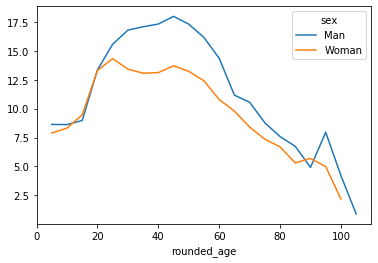

In [17]:
# average speed by age and sex
x = df.groupby(["rounded_age", "sex"]).agg({"speed":"mean"})
x = x.reset_index().pivot(index='rounded_age', columns='sex', values='speed')
x.plot()

In [18]:
# speed by mode and sex
df.groupby(["sex", "mode_simple"]).speed.describe()

count       mean        std  min       25%  \
sex   mode_simple                                                      
Man   car               44304.0  21.925916  16.179870  0.0  9.152454   
      other              2708.0  16.231940  13.733976  0.0  7.049733   
      public transport  22336.0  12.574530   9.683606  0.0  6.535480   
      walk              32154.0   2.584607   2.372329  0.0  1.388628   
Woman car               45546.0  20.123352  15.159405  0.0  8.449581   
      other               775.0  12.361797  10.800769  0.0  5.810543   
      public transport  32113.0  11.674829   8.863175  0.0  6.310020   
      walk              42661.0   2.523435   1.963335  0.0  1.402549   

                              50%        75%         max  
sex   mode_simple                                         
Man   car               17.397114  31.201447  145.303594  
      other             11.792933  21.097021  138.721951  
      public transport   9.586322  15.654492  141.592342  
      walk               2.381501   3.533331  144.425398  
Woman car               15.283129  27.914245  145.371572  
      other              9.489065  14.783374   67.854716  
      public transport   8.968342  14.301849  149.810836  
      walk               2.333292   3.448100  119.665207

**weighted pt speed**

only comparing speed public transport trips

In [36]:
# get the weighted mean speed for public transport
df_pt_sex_sum = df.loc[df.mode_simple == "public transport", ].groupby("sex").sum()
df_pt_sex_sum.weighted_speed / df_pt_sex_sum.ELE_G_POND_ESC2 

sex
Man      12.406572
Woman    11.334209
dtype: float64

**weighted car speed**

only comparing speed of trips of cars

In [38]:
# get the weighted mean speed for public transport
df_car_sex_sum = df.loc[df.mode_simple == "car", ].groupby("sex").sum()
df_car_sex_sum.weighted_speed / df_car_sex_sum.ELE_G_POND_ESC2 

sex
Man      21.872648
Woman    19.681331
dtype: float64

**weighted walking speed**

only comparing speed of walked trips

In [39]:
# get the weighted mean speed for public transport
df_walk_sex_sum = df.loc[df.mode_simple == "walk", ].groupby("sex").sum()
df_walk_sex_sum.weighted_speed / df_walk_sex_sum.ELE_G_POND_ESC2 

sex
Man      2.541880
Woman    2.504671
dtype: float64

### legs (etapas)

In [41]:
# average legs by sex
df.groupby(["sex"]).N_ETAPAS_POR_VIAJE.describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Man,101580.0,1.136011,0.444797,1.0,1.0,1.0,1.0,6.0
Woman,121164.0,1.169836,0.493473,1.0,1.0,1.0,1.0,6.0


In [42]:
# weighted average legs
df["weighted_legs"] = df.N_ETAPAS_POR_VIAJE * df.ELE_G_POND_ESC2

# get the weighted mean legs count
df_sex_sum = df.groupby("sex").sum()
df_sex_sum.weighted_legs / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      1.138136
Woman    1.170062
dtype: float64

In [43]:
# check: multiple legs only with public transport
df.groupby(["mode_simple"]).mean().N_ETAPAS_POR_VIAJE

mode_simple
car                 1.001279
other               1.000000
public transport    1.629330
walk                1.000000
Name: N_ETAPAS_POR_VIAJE, dtype: float64

In [76]:
# average legs by gender only for public transport trips
df[df.mode_simple == "public transport"].groupby("sex").mean().N_ETAPAS_POR_VIAJE

sex
Man      1.616004
Woman    1.638599
Name: N_ETAPAS_POR_VIAJE, dtype: float64

In [77]:
# weighted average legs for public transport

df_sex_sum = df.loc[df.mode_simple == "public transport", ].groupby("sex").sum()
df_sex_sum.weighted_legs / df_sex_sum.ELE_G_POND_ESC2 

sex
Man      1.624611
Woman    1.618434
dtype: float64

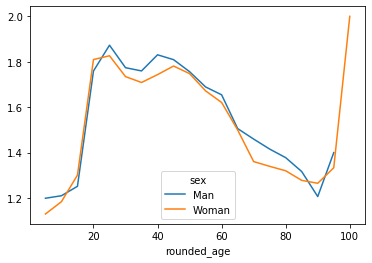

In [80]:
# average legs by age and sex
x = df.loc[df.mode_simple == "public transport"].groupby(["rounded_age", "sex"]).agg({"N_ETAPAS_POR_VIAJE":"mean"})
x = x.reset_index().pivot(index='rounded_age', columns='sex', values='N_ETAPAS_POR_VIAJE')
x.plot()

### main activity

In [23]:
# main activity of indivudals by sex
df.groupby(["sex"]).activity_simple.value_counts(normalize = True)

sex    activity_simple       
Man    working                   0.474748
       not working               0.279302
       student                   0.237037
       domestic and care work    0.008912
Woman  working                   0.459152
       not working               0.263013
       student                   0.162683
       domestic and care work    0.115152
Name: activity_simple, dtype: float64

### trip motive

In [24]:
# motive for trip by sex
df.groupby(["sex"]).motive_simple.value_counts(normalize = True)

sex    motive_simple   
Man    work                0.301792
       leisure / sports    0.300010
       care                0.196958
       study               0.178893
       other               0.022347
Woman  care                0.312131
       leisure / sports    0.279737
       work                0.257205
       study               0.125681
       other               0.025247
Name: motive_simple, dtype: float64

In [25]:
# average distance by motive
df.groupby(["motive_simple"]).DISTANCIA_VIAJE.mean()

motive_simple
care                 3.615657
leisure / sports     6.584344
other               19.904117
study                5.069237
work                11.767304
Name: DISTANCIA_VIAJE, dtype: float64

In [26]:
#average speed by motive
df.groupby(["motive_simple"]).speed.mean()

motive_simple
care                10.200145
leisure / sports    10.328908
other               12.082645
study                9.972583
work                18.404843
Name: speed, dtype: float64

### time of day

In [81]:
df.loc[df.start_time.notna(), "start_hour"] = df.loc[df.start_time.notna(), "start_time"].apply(lambda x: x.hour)

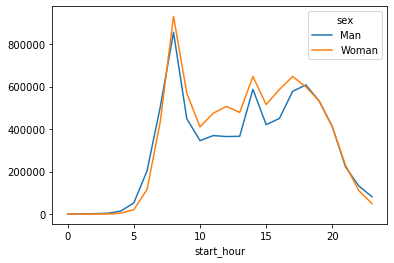

In [82]:
# weighted count of trips by sex and daytime
g = df.groupby(["sex", "start_hour"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()
g_plot = g.pivot(index='start_hour', columns='sex', values='ELE_G_POND_ESC2')
g_plot.plot(kind = "line")

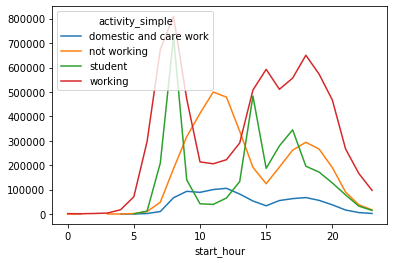

In [83]:
# weighted count of trips by main activity
g = df.groupby(["activity_simple", "start_hour"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()

g_plot = g.pivot(index='start_hour', columns='activity_simple', values='ELE_G_POND_ESC2')

g_plot.plot(kind = "line")

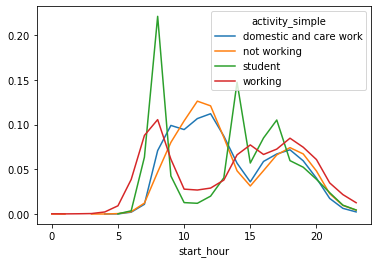

In [84]:
# percentage values
df_perc = g_plot / g_plot.sum()
df_perc.plot(kind = "line")

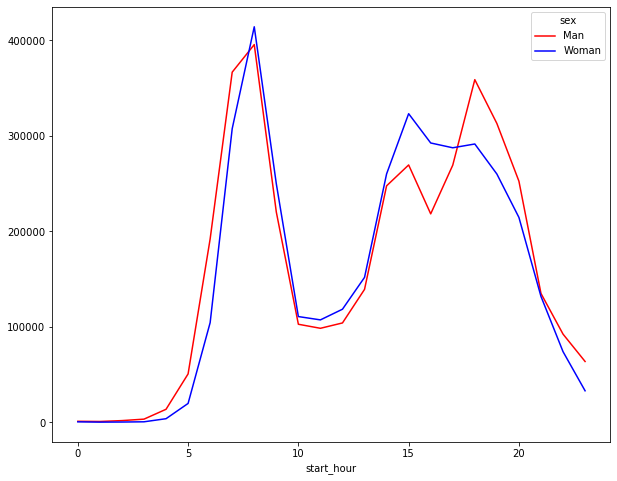

In [85]:
# weighted only working by gender
g = df[df.activity_simple == "working"].groupby(["sex", "start_hour"]).agg({"ELE_G_POND_ESC2": "sum"}).reset_index()
g_plot = g.pivot(index='start_hour', columns='sex', values='ELE_G_POND_ESC2')

g_plot.plot(kind = "line", figsize = (10,8), color = ["red", "blue"])

In [86]:
g

,sex,start_hour,ELE_G_POND_ESC2
0,Man,0.0,1096.614664
1,Man,1.0,908.650210
2,Man,2.0,1827.859643
3,Man,3.0,3355.498136
4,Man,4.0,13673.996847
5,Man,5.0,50717.845613
6,Man,6.0,192081.764366
7,Man,7.0,366729.780444
8,Man,8.0,395601.142566
9,Man,9.0,220260.070046
